In [1]:
!pip install transformers -q
!pip install sentencepiece -q
!pip install editdistance -q

     |████████████████████████████████| 3.1 MB 15.1 MB/s 
     |████████████████████████████████| 596 kB 71.1 MB/s 
     |████████████████████████████████| 895 kB 57.3 MB/s 
     |████████████████████████████████| 3.3 MB 47.3 MB/s 
     |████████████████████████████████| 61 kB 523 kB/s 
     |████████████████████████████████| 1.2 MB 14.9 MB/s 


In [2]:
# Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [4]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import editdistance

In [21]:
# Load the test paraphrase file containing predictions from the best performing model
model_test = pd.read_csv(D+"/predicted_text/siamese_evaluations_of_translations/3dense_wpb_para_test_eval.csv")
model_test.drop(columns={'Unnamed: 0'}, inplace=True)

In [22]:
# View the first few records in each file
model_test.head()

,language,actual_label,predicted_label,para_prob,sentence_1,sentence_2
0,translate English to Hindi,0,0,0.253630,निशा प्रतिदिन दादी को सीतारामजी के मंदिर में द...,जयपुर-कोटा के बीच 248 किलोमीटर की दूरी होने के...
1,translate English to Hindi,0,0,0.015686,मनरेगा के मजदूर पीएम मोदी को लौटाएंगे पांच रुपए,मिलान कोर्ट ऑफ अपील्स के आदेश के बाद पहली बा...
2,translate English to Hindi,1,1,0.632113,पाकिस्तान को दिया करारा जवाब,पाक को दिया मुंहतोड़ जवाब
3,translate English to Hindi,0,0,0.035219,स्कूल में दो बिल्डिंग हैं।,"जिस समय पुलिस स्कूल पहुंची, उस समय करीब पांच ह..."
4,translate English to Hindi,1,1,0.989238,रेप के मामले में वह पीड़िता से समझौते का दवाब ...,वह पीड़िता से रेप के मामले में समझौते का दवाब ब...


In [11]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def sentence_embeddings(device, tokenizer, model, sentences):
  """Create contextualized sentence embeddings
  
  Parameters:
  tokenizer: transformers tokenizer for creating word tokens
  model:
  sentences: sentences to generate sentence embeddings for
  """

  # Tokenize sentences and return PyTorch tensors
  encoded_input = tokenizer(sentences, padding=True, truncation=True, 
                            max_length=128, return_tensors='pt')
  encoded_input = encoded_input.to(device)
  
  # Pass the tokenized input to the model 
  with torch.no_grad():
    model.to(device)
    model_output = model(**encoded_input) 
  
  # Perform mean pooling to get total sentence embeddings
  sentence_embeddings = mean_pooling(model_output, 
                                     encoded_input['attention_mask'])
  
  return sentence_embeddings

In [12]:
# Get the sentence embeddings and cosine similarity scores between each pair of sentences in the dataset
# This is to check if low scoring sentences have exact similarity scores or if they are of low quality
def check_cosine_similarity(df, device, tokenizer, model):

  # Create an empty list to check cosine similarity scores
  cosine_scores = []

  for index, rows in df.iterrows():
    # Get the sentence embeddings of each pair of target sentences
    sent1_embed = sentence_embeddings(device, tokenizer, model, rows['sentence_1'])
    sent2_embed = sentence_embeddings(device, tokenizer, model, rows['sentence_2'])

    # Reshape the embeddings to be of a single dimension 
    # Get the cosine similarity between the two pairs of sentence embeddings
    cosine_similarity_value = F.cosine_similarity(sent1_embed.squeeze(0), sent2_embed.squeeze(0), dim=0)

    # Add the cosine similarity score to the list of scores
    cosine_scores.append(cosine_similarity_value.item())

  return cosine_scores

In [23]:
def get_metrics(df):
  """A function that returns the dataframe with new columns for bart and indictrans cosine scores and edit distances"""

  # Set up the device to run on GPU if available
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  # Set the tokenizer and model as IndicBert Tokenizer and IndicBert model 
  tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
  model = AutoModel.from_pretrained('ai4bharat/indic-bert')

  # Get the cosine similarity scores for bart and indictrans
  df['cosine_similarity_scores'] = check_cosine_similarity(df, device, tokenizer, model)

  # Get the edit distance to convert sentence 2 to sentence 1
  df['edit_d'] = df.apply(lambda x: editdistance.eval(x['sentence_1'], x['sentence_2']), axis=1)

  return df
  

In [24]:
# Add the cosine similarity scores and edit distances to the dataframe
model_test = get_metrics(model_test)

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'sop_classifier.classifier.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# View the first few records in each file
model_test.head()

,language,actual_label,predicted_label,para_prob,sentence_1,sentence_2,cosine_similarity_scores,edit_d
0,translate English to Hindi,0,0,0.253630,निशा प्रतिदिन दादी को सीतारामजी के मंदिर में द...,जयपुर-कोटा के बीच 248 किलोमीटर की दूरी होने के...,0.857701,77
1,translate English to Hindi,0,0,0.015686,मनरेगा के मजदूर पीएम मोदी को लौटाएंगे पांच रुपए,मिलान कोर्ट ऑफ अपील्स के आदेश के बाद पहली बा...,0.636454,50
2,translate English to Hindi,1,1,0.632113,पाकिस्तान को दिया करारा जवाब,पाक को दिया मुंहतोड़ जवाब,0.662269,14
3,translate English to Hindi,0,0,0.035219,स्कूल में दो बिल्डिंग हैं।,"जिस समय पुलिस स्कूल पहुंची, उस समय करीब पांच ह...",0.706535,57
4,translate English to Hindi,1,1,0.989238,रेप के मामले में वह पीड़िता से समझौते का दवाब ...,वह पीड़िता से रेप के मामले में समझौते का दवाब ब...,0.982425,22


For correctly labeled examples, the model has high confidence in their labels (95% or higher). Incorrectly predicted examples are predicted with a high degree of confidence as well, but less so than correct predictions.

In [26]:
# Create two sets - 1 for correct predictions, 1 for incorrect predictions
correct = model_test[model_test.actual_label == model_test.predicted_label]
incorrect = model_test[model_test.actual_label != model_test.predicted_label]

In [30]:
# Correctly labeled NP pairs have a median P probability of 0.05, with 75% of scores 0.14 or lower
print(correct[correct.actual_label == 0].para_prob.describe(),"\n")
# Correctly labeled P pairs have a median P probability of 0.96
print(correct[(correct.actual_label == 1) ].para_prob.describe(),"\n")
# NP pairs incorrectly labeled as P have a median P probability of 0.77
print(incorrect[incorrect.actual_label == 0].para_prob.describe(),"\n")
# P pairs incorrectly labeled as NP have a median P probability of 0.15
print(incorrect[(incorrect.actual_label == 1) ].para_prob.describe())

count    757.000000
mean       0.107507
std        0.118598
min        0.008872
25%        0.025336
50%        0.053780
75%        0.142035
max        0.498883
Name: para_prob, dtype: float64 

count    522.000000
mean       0.901194
std        0.120851
min        0.506536
25%        0.860214
50%        0.961585
75%        0.983258
max        0.991074
Name: para_prob, dtype: float64 

count    124.000000
mean       0.761161
std        0.149478
min        0.500262
25%        0.642927
50%        0.767943
75%        0.892050
max        0.986168
Name: para_prob, dtype: float64 

count    171.000000
mean       0.195258
std        0.141757
min        0.016609
25%        0.075078
50%        0.152915
75%        0.308002
max        0.484340
Name: para_prob, dtype: float64


In [32]:
# For correctly labeled Hi pairs, the model has a high degree of confidence that the chosen label is correct
print(correct[(correct.actual_label == 0) & (correct.language == 'translate English to Hindi')].para_prob.describe(),"\n")
print(correct[(correct.actual_label == 1) & (correct.language == 'translate English to Hindi')].para_prob.describe(),"\n")
# The model is less confident in incorrectly labeled NP as P pairs and incorrectly labeled P as NP pairs
print(incorrect[(incorrect.actual_label == 0) & (incorrect.language == 'translate English to Hindi')].para_prob.describe(),"\n")
print(incorrect[(incorrect.actual_label == 1) & (incorrect.language == 'translate English to Hindi')].para_prob.describe())

count    222.000000
mean       0.096048
std        0.112784
min        0.010386
25%        0.024482
50%        0.046096
75%        0.105601
max        0.477944
Name: para_prob, dtype: float64 

count    166.000000
mean       0.926701
std        0.109879
min        0.524649
25%        0.936937
50%        0.974376
75%        0.985794
max        0.991074
Name: para_prob, dtype: float64 

count    29.000000
mean      0.734576
std       0.152396
min       0.522136
25%       0.615845
50%       0.697711
75%       0.873797
max       0.983656
Name: para_prob, dtype: float64 

count    31.000000
mean      0.263808
std       0.148036
min       0.022436
25%       0.121810
50%       0.252776
75%       0.410724
max       0.468493
Name: para_prob, dtype: float64


In [31]:
# For correctly labeled Tamil pairs, the model has a high degree of confidence that the chosen label is correct
print(correct[(correct.actual_label == 0) & (correct.language == 'translate English to Tamil')].para_prob.describe(),"\n")
print(correct[(correct.actual_label == 1) & (correct.language == 'translate English to Tamil')].para_prob.describe(),"\n")
# The model has a high degree of confidence in incorrectly labeled NP as P pairs and incorrectly labeled P as NP pairs
print(incorrect[(incorrect.actual_label == 0) & (incorrect.language == 'translate English to Tamil')].para_prob.describe(),"\n")
print(incorrect[(incorrect.actual_label == 1) & (incorrect.language == 'translate English to Tamil')].para_prob.describe())

count    206.000000
mean       0.124147
std        0.123664
min        0.011169
25%        0.033492
50%        0.078824
75%        0.167727
max        0.498330
Name: para_prob, dtype: float64 

count    91.000000
mean      0.810005
std       0.139041
min       0.506536
25%       0.711931
50%       0.843414
75%       0.935547
max       0.987942
Name: para_prob, dtype: float64 

count    47.000000
mean      0.794785
std       0.155278
min       0.501581
25%       0.682352
50%       0.840983
75%       0.933310
max       0.986168
Name: para_prob, dtype: float64 

count    82.000000
mean      0.157924
std       0.128312
min       0.017915
25%       0.045258
50%       0.121227
75%       0.233165
max       0.466969
Name: para_prob, dtype: float64


In [33]:
# For correctly labeled Ml pairs, the model has a high degree of confidence that the chosen label is correct
print(correct[(correct.actual_label == 0) & (correct.language == 'translate English to Malayalam')].para_prob.describe(),"\n")
print(correct[(correct.actual_label == 1) & (correct.language == 'translate English to Malayalam')].para_prob.describe(),"\n")
# The model has a high degree of confidence in incorrectly labeled NP as P pairs and relatively high degree of confidence in incorrectly labeled P as NP pairs
print(incorrect[(incorrect.actual_label == 0) & (incorrect.language == 'translate English to Malayalam')].para_prob.describe(),"\n")
print(incorrect[(incorrect.actual_label == 1) & (incorrect.language == 'translate English to Malayalam')].para_prob.describe())

count    213.000000
mean       0.144334
std        0.127944
min        0.014465
25%        0.039916
50%        0.094197
75%        0.228173
max        0.498883
Name: para_prob, dtype: float64 

count    137.000000
mean       0.867860
std        0.122053
min        0.516612
25%        0.806059
50%        0.915374
75%        0.962109
max        0.986274
Name: para_prob, dtype: float64 

count    45.000000
mean      0.735899
std       0.136447
min       0.500262
25%       0.614084
50%       0.745771
75%       0.849001
max       0.952307
Name: para_prob, dtype: float64 

count    55.000000
mean      0.211433
std       0.141868
min       0.016609
25%       0.108937
50%       0.170173
75%       0.322853
max       0.484340
Name: para_prob, dtype: float64


In [34]:
# Get the min and max of cosine similarity values for incorrect and correct examples
print(min(correct.cosine_similarity_scores))
print(max(correct.cosine_similarity_scores), "\n")

# The incorrect examples have a higher minimum cosine similarity score than that of the minimum of correctly labeled examples
print(min(incorrect.cosine_similarity_scores))
print(max(incorrect.cosine_similarity_scores))

0.47781768441200256
0.9975895881652832 

0.5206342935562134
1.0


In [35]:
# Get the min and max values for paraphrases vs not paraphrases
p = model_test[model_test.actual_label == 1]
np = model_test[model_test.actual_label == 0]

In [36]:
# Get the min and max of cosine similarity values for paraphrases versus not paraphrases
print(min(p.cosine_similarity_scores))
print(max(p.cosine_similarity_scores), "\n")


print(min(np.cosine_similarity_scores))
print(max(np.cosine_similarity_scores))

0.5206342935562134
0.9975895881652832 

0.47781768441200256
1.0


In [38]:
# Replace the long translation task text strings in-place with just the language names
model_test["language"] = model_test["language"].str.replace("translate English to Hindi", "Hindi", case = False)
model_test["language"] = model_test["language"].str.replace("translate English to Punjabi", "Punjabi", case = False)
model_test["language"] = model_test["language"].str.replace("translate English to Tamil", "Tamil", case = False)
model_test["language"] = model_test["language"].str.replace("translate English to Malayalam", "Malayalam", case = False)

In [39]:
model_test

,language,actual_label,predicted_label,para_prob,sentence_1,sentence_2,cosine_similarity_scores,edit_d
0,Hindi,0,0,0.253630,निशा प्रतिदिन दादी को सीतारामजी के मंदिर में द...,जयपुर-कोटा के बीच 248 किलोमीटर की दूरी होने के...,0.857701,77
1,Hindi,0,0,0.015686,मनरेगा के मजदूर पीएम मोदी को लौटाएंगे पांच रुपए,मिलान कोर्ट ऑफ अपील्स के आदेश के बाद पहली बा...,0.636454,50
2,Hindi,1,1,0.632113,पाकिस्तान को दिया करारा जवाब,पाक को दिया मुंहतोड़ जवाब,0.662269,14
3,Hindi,0,0,0.035219,स्कूल में दो बिल्डिंग हैं।,"जिस समय पुलिस स्कूल पहुंची, उस समय करीब पांच ह...",0.706535,57
4,Hindi,1,1,0.989238,रेप के मामले में वह पीड़िता से समझौते का दवाब ...,वह पीड़िता से रेप के मामले में समझौते का दवाब ब...,0.982425,22
...,...,...,...,...,...,...,...,...
1569,Punjabi,1,1,0.973717,ਸਿੰਧੂ ਦੇ ਗਲ ਚਾਂਦੀ ਜਦਕਿ ਸਾਕਸ਼ੀ ਦੇ ਹਿੱਸੇ ਕਾਂਸੇ ਦਾ...,ਸਾਕਸ਼ੀ ਦੇ ਹਿੱਸੇ ਕਾਂਸੇ ਦਾ ਜਦਕਿ ਸਿੰਧੂ ਦੇ ਗਲ ਚਾਂਦੀ...,0.933831,28
1570,Punjabi,0,0,0.015794,ਗੁਰੂ ਨਾਨਕ ਦੇਵ ਯੂਨੀਵਰਸਿਟੀ ਦੇ ਪ੍ਰੋ. ਜਗਰੂਪ ਸਿੰਘ ਸ...,ਇਸ ਤੋਂ ਇਲਾਵਾ ਦਿੱਲੀ ਵਿੱਚ ਪਾਰਟੀ ਦੇ ਇੱਕ ਦਰਜਨ ਵਿਧ...,0.834794,100
1571,Punjabi,1,1,0.945135,ਦੂਜੇ ਪਾਸੇ ਲੋਕ ਸਭਾ ਹਲਕਾ ਨਿਗਰਾਨ ਅਕੁੰਸ਼ ਨਾਰੰਗ ਨੇ ਕ...,ਦੂਜੇ ਪਾਸੇ ਅਕੁੰਸ਼ ਨਾਰੰਗ ਜੋ ਕਿ ਲੋਕ ਸਭਾ ਹਲਕਾ ਨਿਗਰ...,0.920744,59
1572,Punjabi,1,1,0.975044,ਅਦਾਲਤੀ ਹੁਕਮਾਂ ਤਹਿਤ 10 ਸਤੰਬਰ ਨੂੰ ਇਸ ਧਾਰਮਿਕ ਅਸਥਾ...,10 ਸਤੰਬਰ ਨੂੰ ਅਦਾਲਤੀ ਹੁਕਮਾਂ ਤਹਿਤ ਇਸ ਧਾਰਮਿਕ ਅਸਥਾ...,0.966978,36


In [40]:
model_test.language.unique()

array(['Hindi', 'Malayalam', 'Tamil', 'Punjabi'], dtype=object)

In [41]:
# Map the 0 and 1 labels back to the original NP and P values
model_test["actual_label"] = model_test["actual_label"].map({0: "NP", 1: "P"})
model_test["predicted_label"] = model_test["predicted_label"].map({0: "NP", 1: "P"})

Text(0.5, 1.0, 'Cosine Similarity Scores by Language and Actual Label')

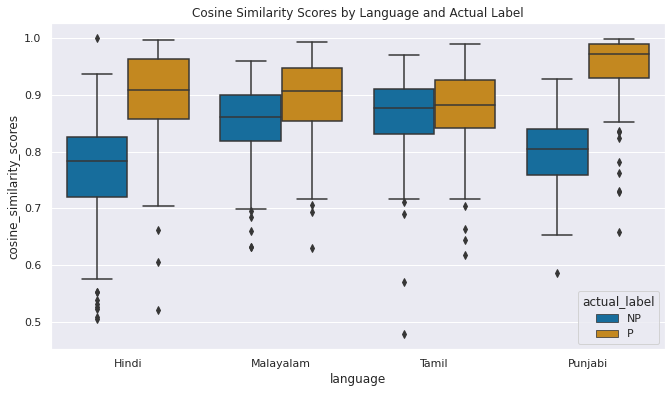

In [42]:
sns.set(rc={'figure.figsize':(11,6)})
sns.boxplot(x = model_test['language'],
            y = model_test['cosine_similarity_scores'],
            hue = model_test['actual_label'], palette="colorblind").set_title('Cosine Similarity Scores by Language and Actual Label')

Text(0.5, 1.0, 'Cosine Similarity Scores of P Predicted to be NP')

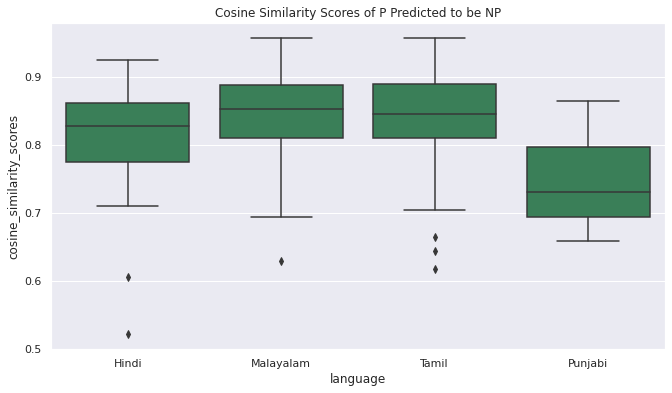

In [43]:
# Let's look at the separation in cosine scores for incorrectly labeled examples that are paraphrases, but the model predicts them not to be
pred_0_actual_1 = model_test[(model_test.predicted_label == "NP") & (model_test.actual_label == "P")]
sns.boxplot(x = pred_0_actual_1['language'],
            y = pred_0_actual_1['cosine_similarity_scores'],color="seagreen").set_title('Cosine Similarity Scores of P Predicted to be NP')


Text(0.5, 1.0, 'Cosine Similarity Scores of NP Predicted to be P')

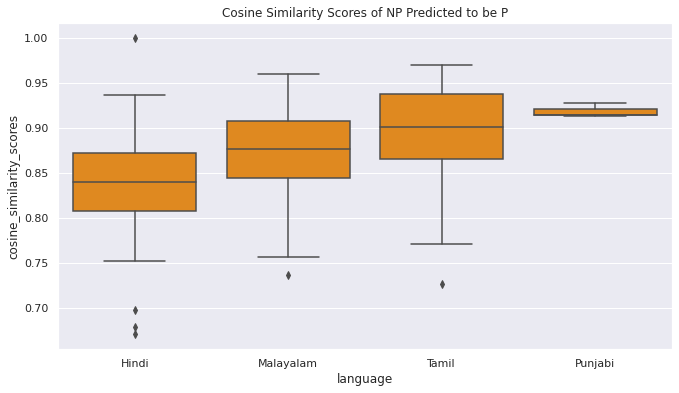

In [44]:
# Let's look at the separation in cosine scores for incorrectly labeled examples that are not paraphrases, but the model predicts them to be
pred_1_actual_0 = model_test[(model_test.predicted_label == "P") & (model_test.actual_label == "NP")]
sns.boxplot(x = pred_1_actual_0['language'],
            y = pred_1_actual_0['cosine_similarity_scores'],color="darkorange").set_title('Cosine Similarity Scores of NP Predicted to be P')


In [45]:
# Look at an example sentence where the model is predicting not paraphrase for Tamil sentences that are paraphrases - the most frequent model mistake
pred_1_actual_0_ta = pred_1_actual_0[pred_1_actual_0.language == 'Tamil'].reset_index().sort_values("cosine_similarity_scores", ascending=False)
# All of these sentences have high cosine similarity scores
pred_1_actual_0_ta.head()

,index,language,actual_label,predicted_label,para_prob,sentence_1,sentence_2,cosine_similarity_scores,edit_d
23,1117,Tamil,NP,P,0.724123,மலேசிய நாட்டின் தலைநகரான கோலாலம்பூரில் வெள்ளைய...,இந்திய பிரதமர் நரேந்திர மோடி கடந்த ஆண்டு மலேசி...,0.969548,125
41,1284,Tamil,NP,P,0.771697,காந்திய மக்கள் இயக்கத்தை சேர்ந்தவர்கள் பா.ஜனதா...,அப்போது காந்திய மக்கள் இயக்கத்தின் மாநில துணை ...,0.964917,89
43,1306,Tamil,NP,P,0.986168,ஹராரேயில் நடைபெற்ற 2-வது டி20 போட்டியில் இந்தி...,இந்தியா- ஜிம்பாப்வே அணிகளுக்கு இடையிலான 2-வது ...,0.963441,78
29,1182,Tamil,NP,P,0.838569,"கல்லூரி மாணவ -மாணவிகள், பள்ளி மாணவர்கள் அரசு அ...",மாணவர்களுக்கு யோகாசன பயிற்சி மிகவும் அவசியம் எ...,0.952959,169
27,1164,Tamil,NP,P,0.852661,"சர்வதேச யோகா தினமான ஜூன் 21-ம்தேதி, இந்தியா ம...","பிரதமர் நரேந்திரமோடியின் வேண்டுகோளை ஏற்று, ஜ...",0.949880,98


In [48]:
# For each label category, find the min, median, max, and quartiles
# NP pairs generally have a greater edit distance than P pairs
print(model_test.groupby('actual_label', as_index=False)['edit_d'].describe())

actual_label  0         NP
              1          P
count         0        881
              1        693
mean          0    89.1237
              1    52.7908
std           0    33.9832
              1    28.7335
min           0          0
              1          4
25%           0         65
              1         31
50%           0         84
              1         47
75%           0        107
              1         71
max           0        236
              1        199
dtype: object


In [52]:
# Check the edit distance of incorrectly labeled sentence pairs
# Incorrectly labeled NP pairs have a median distance near the 3rd quartile edit distance of P pairs
# Incorrectly labeled P pairs have a median edit distance near the 25th percentile edit distance of NP pairs
print(incorrect.groupby('actual_label', as_index=False)['edit_d'].describe())

actual_label  0      0.000000
              1      1.000000
count         0    124.000000
              1    171.000000
mean          0     74.991935
              1     68.543860
std           0     29.675616
              1     30.891691
min           0      0.000000
              1     11.000000
25%           0     57.000000
              1     46.500000
50%           0     72.000000
              1     63.000000
75%           0     88.000000
              1     86.000000
max           0    169.000000
              1    199.000000
dtype: float64


Text(0.5, 1.0, 'Cosine Similarity Scores by Language and Actual Label, Predicted Label')

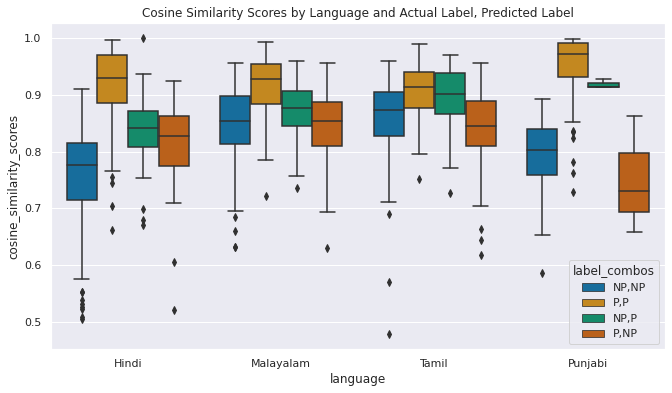

In [61]:
# Get the distribution of cosine similarity scores by actual label/predicted label combinations and languages
model_test['label_combos'] = model_test['actual_label'].astype(str) + "," + model_test['predicted_label']

# Plot the distribution of cosine scores
sns.set(rc={'figure.figsize':(11,6)})
sns.boxplot(x = model_test['language'],
            y = model_test['cosine_similarity_scores'],
            hue = model_test['label_combos'], 
            palette="colorblind").set_title('Cosine Similarity Scores by Language and Actual Label, Predicted Label')

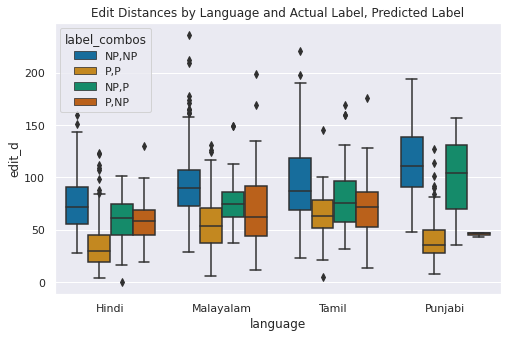

In [56]:
# Plot the distribution of edit distances from the first sentence
sns.set(rc={'figure.figsize':(11,6)})
sns.boxplot(x = model_test['language'],
            y = model_test['edit_d'],
            hue = model_test['label_combos'], palette="colorblind").set_title('Edit Distances by Language and Actual Label, Predicted Label')
plt.gcf().set_size_inches(8, 5)